# Assignment-7 Apply SVM on Donors Choose dataset.

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Loading Data

In [3]:
data = pd.read_csv('preprocessed_data.csv', nrows=50000)
data.head(2)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   
1      140945  p258326  897464ce9ddc600bced1151f324dd63a            Mr.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   
1           FL        2016-10-25 09:22:10             Grades 6-8   

                                      project_title  \
0  Educational Support for English Learners at Home   
1             Wanted: Projector for Hungry Learners   

                                     project_essay_1  \
0  My students are English learners that are work...   
1  Our students arrive to our school eager to lea...   

                                     project_essay_2  ... quantity  \
0  \"The limits of your language are the limits o...  ...       23   
1  The projector we need for our school is very c...  ...        1   

  Numerical digits in summary                                  titles_sw  \
0                           0  educational support english learners home   
1                           0           wanted projector hungry learners   

                                           essays_sw  \
0  my students english learners working english s...   
1  our students arrive school eager learn they po...   

   preprocessed_project_grade_category  \
0                        grades_prek_2   
1                           grades_6_8   

                                 preprocessed_essays  \
0  students english learners working english seco...   
1  students arrive school eager learn polite gene...   

                         preprocessed_titles sentimental_score  \
0  educational support english learners home            0.9735   
1           wanted projector hungry learners            0.9856   

   preprocessed_essay_word_count  preprocessed_title_word_count  
0                            147                              5  
1                             97                              4  

[2 rows x 29 columns]

In [4]:
data['project_is_approved'].value_counts()

1    42286
0     7714
Name: project_is_approved, dtype: int64

In [5]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
0      160221  p253737  c90749f5d961ff158d4b4d1e7dc665fc           Mrs.   

  school_state project_submitted_datetime project_grade_category  \
0           IN        2016-12-05 13:43:57          Grades PreK-2   

                                      project_title  \
0  Educational Support for English Learners at Home   

                                     project_essay_1  \
0  My students are English learners that are work...   

                                     project_essay_2  ... quantity  \
0  \"The limits of your language are the limits o...  ...       23   

  Numerical digits in summary                                  titles_sw  \
0                           0  educational support english learners home   

                                           essays_sw  \
0  my students english learners working english s...   

  preprocessed_project_grade_category  \
0                       grades_prek_2   

                                 preprocessed_essays  \
0  students english learners working english seco...   

                         preprocessed_titles  sentimental_score  \
0  educational support english learners home             0.9735   

   preprocessed_essay_word_count  preprocessed_title_word_count  
0                            147                              5  

[1 rows x 28 columns]

## 1.2 Splitting data into Train and cross validation(or test): Stratified Sampling

In [6]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

## 1.3 Make Data Model Ready: encoding essay, and project_title

### 1.3.1 Vectorizing preprocessed essays & project_title using BOW

In [7]:
# preprocessed essays
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values)  # fit has to happen only on train data

# we use the fit CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_bow = vectorizer.transform(X_test['preprocessed_essays'].values)

(22445, 28) (22445,)
(11055, 28) (11055,)
(16500, 28) (16500,)


In [8]:
print("After vectorization")
print(X_train_essay_bow.shape, y_train.shape)
print(X_cv_essay_bow.shape, y_cv.shape)
print(X_test_essay_bow.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


In [9]:
#project_title
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['preprocessed_titles'].values.astype('U'))

X_train_title_bow = vectorizer.transform(X_train['preprocessed_titles'].values.astype('U'))
X_cv_title_bow = vectorizer.transform(X_cv['preprocessed_titles'].values.astype('U'))
X_test_title_bow = vectorizer.transform(X_test['preprocessed_titles'].values.astype('U'))

In [10]:
print("After vectorization")
print(X_train_title_bow.shape, y_train.shape)
print(X_cv_title_bow.shape, y_cv.shape)
print(X_test_title_bow.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 1607) (22445,)
(11055, 1607) (11055,)
(16500, 1607) (16500,)


### 1.3.2 Vectorizing preprocessed essays & project_title using TFIDF

In [11]:
#TFIDF for preprocessed_essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values)

X_train_essay_tfidf = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['preprocessed_essays'].values)

In [12]:
print("After vectorization")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_cv_essay_tfidf.shape, y_cv.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


In [13]:
#TFIDF for preprocessed_titles
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['preprocessed_titles'].values.astype('U'))

X_train_titles_tfidf = vectorizer.transform(X_train['preprocessed_titles'].values.astype('U'))
X_cv_titles_tfidf = vectorizer.transform(X_cv['preprocessed_titles'].values.astype('U'))
X_test_titles_tfidf = vectorizer.transform(X_test['preprocessed_titles'].values.astype('U'))

In [15]:
print("After vectorization")
print(X_train_titles_tfidf.shape, y_train.shape)
print(X_cv_titles_tfidf.shape, y_cv.shape)
print(X_test_titles_tfidf.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 1607) (22445,)
(11055, 1607) (11055,)
(16500, 1607) (16500,)


### 1.3.3 Vectorizing preprocessed essays & project_title using Avg W2V

#### 1.3.3.1 For preprocessed_titles

In [16]:
#Avg W2V for preprocessed_titles
#Train your own Word2Vec model using your own text corpus
import warnings
warnings.filterwarnings("ignore")
#train data
w2v_data= X_train['preprocessed_titles']
split_title_train=[]
for row in w2v_data: 
    split_title_train.append([word for word in str(row).split()])     #splitting words

#train your W2v
train_w2v = Word2Vec(split_title_train,min_count=1,size=50, workers=4)
word_vectors_train = train_w2v.wv
w2v_words_train =list(word_vectors_train.vocab)
print(len(w2v_words_train ))

7895


In [17]:
# compute average word2vec for each title.
sent_vectors_train = [] # the avg-w2v for each title is stored in this list
for sent in tqdm(split_title_train):   # for each title
    sent_vec = np.zeros(50)  # as word vectors are of zero length 50
    cnt_words =0   # num of words with a valid vector in the title
    for word in sent:   # for each word in a title
        if word in w2v_words_train:
            vec = word_vectors_train[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
        sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[3]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22445/22445 [00:03<00:00, 7414.31it/s]


22445
50


In [18]:
# For CV data 

# compute average word2vec for each title.
sent_vectors_cv = [] # the avg-w2v for each title is stored in this list
for sent in tqdm(X_cv['preprocessed_titles']):   # for each title
    sent_vec = np.zeros(50)  # as word vectors are of zero length 50
    #cnt_words =0   # num of words with a valid vector in the title
    for word in str(sent):   # for each word in a title
        if word in w2v_words_train:
            vec = word_vectors_train[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
        sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[3]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11055/11055 [00:29<00:00, 379.37it/s]


11055
50


In [19]:
# For test data

# compute average word2vec for each title.
sent_vectors_test = [] # the avg-w2v for each title is stored in this list
for sent in tqdm(X_test['preprocessed_titles']):   # for each title
    sent_vec = np.zeros(50)  # as word vectors are of zero length 50
    #cnt_words =0   # num of words with a valid vector in the title
    for word in str(sent):   # for each word in a title
        if word in w2v_words_train:
            vec = word_vectors_train[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
        sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[3]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16500/16500 [00:44<00:00, 371.35it/s]


16500
50


#### 1.3.3.2 For preprocessed_essays

##### Using Pretrained Models: Avg W2V

In [22]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())
print ("Done.",len(model)," words loaded!")

Done. 51510  words loaded!


In [23]:
# Avg W2V for train data
# compute average word2vec for each review.
avg_w2v_essay_train = []   # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays']):   # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sentence.split():  # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_train.append(vector)
print(len(avg_w2v_essay_train))
print(len(avg_w2v_essay_train[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22445/22445 [00:09<00:00, 2267.74it/s]


22445
300


In [24]:
# Avg W2V for cv data

avg_w2v_essay_cv = []   # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['preprocessed_essays']):   # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sentence.split():  # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_cv.append(vector)
print(len(avg_w2v_essay_cv))
print(len(avg_w2v_essay_cv[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11055/11055 [00:04<00:00, 2325.00it/s]


11055
300


In [25]:
# Avg W2V for test data

avg_w2v_essay_test = []   # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['preprocessed_essays']):   # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sentence.split():  # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_test.append(vector)
print(len(avg_w2v_essay_test))
print(len(avg_w2v_essay_test[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16500/16500 [00:07<00:00, 2298.63it/s]


16500
300


### 1.3.4 Vectorizing preprocessed essays & project_title using TFIDF weighted W2V

#### 1.3.4.1 For preprocessed essays

In [26]:
# For train data

tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['preprocessed_essays']) 
#we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words_essays = set(tfidf_model.get_feature_names())

In [27]:
# average Word2Vec using pretrained models
# compute average word2vec for each review.
tfidf_w2v_train_essay = [] # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['preprocessed_essays']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words_essays):
            vec = model[word]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
        tfidf_w2v_train_essay.append(vector)
print(len(tfidf_w2v_train_essay))
print(len(tfidf_w2v_train_essay[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22445/22445 [01:02<00:00, 359.69it/s]


22445
300


In [28]:
#For cv data

tfidf_w2v_cv_essay = [] # the avg-w2v for each sentence/review is stored in this list
for sentence1 in tqdm(X_cv['preprocessed_essays']): # for each review/sentence
    vector1 = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight1 =0; # num of words with a valid vector in the sentence/review
    for word1 in sentence1.split(): # for each word in a review/sentence
        if (word1 in glove_words) and (word1 in tfidf_words_essays):
            vec1 = model[word1]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf1 = dictionary[word1]*(sentence1.count(word1)/len(sentence1.split())) # getting the tfidf value for each word
            vector1 += (vec1 * tf_idf1) # calculating tfidf weighted w2v
            tf_idf_weight1 += tf_idf1
    if tf_idf_weight1 != 0:
        vector1 /= tf_idf_weight1
        tfidf_w2v_cv_essay.append(vector1)
print(len(tfidf_w2v_cv_essay))
print(len(tfidf_w2v_cv_essay[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11055/11055 [00:30<00:00, 383.68it/s]


11055
300


In [29]:
# For test data

tfidf_w2v_test_essay = [] # the avg-w2v for each sentence/review is stored in this list
for sentence2 in tqdm(X_test['preprocessed_essays']): # for each review/sentence
    vector2 = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight2 =0; # num of words with a valid vector in the sentence/review
    for word2 in sentence2.split(): # for each word in a review/sentence
        if (word2 in glove_words) and (word2 in tfidf_words_essays):
            vec2 = model[word2]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf2 = dictionary[word2]*(sentence2.count(word2)/len(sentence2.split())) # getting the tfidf value for each word
            vector2 += (vec2 * tf_idf2) # calculating tfidf weighted w2v
            tf_idf_weight2 += tf_idf2
    if tf_idf_weight2 != 0:
        vector2 /= tf_idf_weight2
        tfidf_w2v_test_essay.append(vector2)
print(len(tfidf_w2v_test_essay))
print(len(tfidf_w2v_test_essay[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16500/16500 [00:45<00:00, 364.75it/s]


16500
300


#### 1.3.4.2 For preprocessed titles

#### Using pretrained models

In [30]:
# For train data

tfidf_model1 = TfidfVectorizer()
tfidf_model1.fit(X_train['preprocessed_titles'].values.astype('U'))
#we are converting a dictionary with word as a key, and the idf as a value
dictionary_title = dict(zip(tfidf_model1.get_feature_names(), list(tfidf_model1.idf_)))
tfidf_words_titles = set(tfidf_model1.get_feature_names())

In [33]:
# average Word2Vec using pretrained models
# compute average word2vec for each review.
tfidf_w2v_train_title = [] # the avg-w2v for each sentence/review is stored in this list
for sentence_title in tqdm(X_train['preprocessed_titles']): # for each review/sentence
    vector3 = np.zeros(300) # as word vectors are of zero length
    #tf_idf_weight3=0; # num of words with a valid vector in the sentence/review
    for word3 in str(sentence_title).split(): # for each word in a review/sentence
        if (word3 in glove_words) and (word3 in tfidf_words_titles):
            vec4 = model[word3]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf3 = dictionary_title[word3]*(sentence_title.count(word3)/len(str(sentence_title).split())) # getting the tfidf value for each word
            vector3 += (vec4 * tf_idf3) # calculating tfidf weighted w2v
            tf_idf_weight3 += tf_idf3
    if tf_idf_weight3 != 0:
        vector3 /= tf_idf_weight3
        tfidf_w2v_train_title.append(vector3)
print(len(tfidf_w2v_train_title))
print(len(tfidf_w2v_train_title[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22445/22445 [00:01<00:00, 18771.44it/s]


22445
300


In [68]:
# For cv data
tfidf_w2v_cv_title = [] # the avg-w2v for each sentence/review is stored in this list
for sentence_cv in tqdm(X_cv['preprocessed_titles']): # for each review/sentence
    vector4 = np.zeros(300) # as word vectors are of zero length
    #tf_idf_weight4 =0; # num of words with a valid vector in the sentence/review
    for word4 in str(sentence_cv).split(): # for each word in a review/sentence
        if (word4 in glove_words) and (word4 in tfidf_words_titles):
            vec5 = model[word4]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf4 = dictionary_title[word4]*(sentence_cv.count(word4)/len(str(sentence_cv).split())) # getting the tfidf value for each word
            vector4 += (vec5 * tf_idf4) # calculating tfidf weighted w2v
            tf_idf_weight4 += tf_idf4
    if tf_idf_weight4 != 0: 
        vector4 /= tf_idf_weight4
        tfidf_w2v_cv_title.append(vector4)
print(len(tfidf_w2v_cv_title))
print(len(tfidf_w2v_cv_title[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11055/11055 [00:00<00:00, 17976.88it/s]


11055
300


In [36]:
# For test data
tfidf_w2v_test_title = [] # the avg-w2v for each sentence/review is stored in this list
for sentence_test in tqdm(X_test['preprocessed_titles']): # for each review/sentence
    vector5 = np.zeros(300) # as word vectors are of zero length
    #tf_idf_weight5 =0; # num of words with a valid vector in the sentence/review
    for word5 in str(sentence_test).split(): # for each word in a review/sentence
        if (word5 in glove_words) and (word5 in tfidf_words_titles):
            vec6 = model[word5]  # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf5 = dictionary_title[word5]*(sentence_test.count(word5)/len(str(sentence_test).split())) # getting the tfidf value for each word
            vector5 += (vec6 * tf_idf5) # calculating tfidf weighted w2v
            tf_idf_weight5 += tf_idf5
    if tf_idf_weight5 != 0:    
        vector5 /= tf_idf_weight5
        tfidf_w2v_test_title.append(vector5)
print(len(tfidf_w2v_test_title))
print(len(tfidf_w2v_test_title[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 19371.03it/s]


16500
300


## 1.4 Make Data Model Ready: encoding numerical, categorical features

### 1.4.1 Encoding categorical features: School State

In [37]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state = vectorizer.transform(X_train['school_state'].values)
X_cv_state = vectorizer.transform(X_cv['school_state'].values)
X_test_state = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state.shape, y_train.shape)
print(X_cv_state.shape, y_cv.shape)
print(X_test_state.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### 1.4.2 Encoding categorical features: teacher_prefix

In [39]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) 

X_train_teacher = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher.shape, y_train.shape)
print(X_cv_teacher.shape, y_cv.shape)
print(X_test_teacher.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['mr', 'mrs', 'ms', 'none', 'teacher']


### 1.4.3 Encoding categorical features: project_grade_category

In [40]:
#This step is to intialize a vectorizer with vocab from train data
#Ref: https://www.kaggle.com/shashank49/donors-choose-knn#Concatinating-all-features-(TFIDF)
from collections import Counter
my_counter = Counter()
for word in X_train['project_grade_category'].values:
    my_counter.update([word[i:i+14] for i in range(0, len(word),14)]) #https://www.geeksforgeeks.org/python-string-split/

# dict sort by value python: https://stackoverflow.com/a/613218/4084039
project_grade_category_dict = dict(my_counter)
sorted_project_grade_category_dict = dict(sorted(project_grade_category_dict.items(), key=lambda kv: kv[1]))

In [41]:
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_category_dict.keys()), lowercase=False, binary=True,max_features=4)
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade.shape, y_train.shape)
print(X_cv_grade.shape, y_cv.shape)
print(X_test_grade.shape, y_test.shape)
print(vectorizer.get_feature_names())

After vectorizations
(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['Grades 9-12', 'Grades 6-8', 'Grades 3-5', 'Grades PreK-2']


### 1.4.4 Encoding categorical features: clean_categories

In [42]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat = vectorizer.transform(X_train['clean_categories'].values)
X_cv_cat = vectorizer.transform(X_cv['clean_categories'].values)
X_test_cat = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_cat.shape, y_train.shape)
print(X_cv_cat.shape, y_cv.shape)
print(X_test_cat.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### 1.4.5 Encoding categorical features: clean_subcategories

In [43]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subcat = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_subcat = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_subcat = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcat.shape, y_train.shape)
print(X_cv_subcat.shape, y_cv.shape)
print(X_test_subcat.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### 1.4.6 Encoding numerical features: Price

In [55]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
# normalizer.fit(X_train['price'].values)
#this will rise an error Expected 2D array, got 1D array instead:
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 1.4.7 Encoding numerical features: Quantity

In [56]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(1,-1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(1,-1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_cv_quantity_norm.shape, y_cv.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 1.4.8 Encoding numerical features: teacher_number_of_previously_posted_projects

In [57]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_projects_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_projects_norm.shape, y_train.shape)
print(X_cv_projects_norm.shape, y_cv.shape)
print(X_test_projects_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 1.4.9 Encoding numerical features: sentimental_score

In [58]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X_train['sentimental_score'].values.reshape(1,-1))

X_train_senti_norm = normalizer.transform(X_train['sentimental_score'].values.reshape(1,-1))
X_cv_senti_norm = normalizer.transform(X_cv['sentimental_score'].values.reshape(1,-1))
X_test_senti_norm = normalizer.transform(X_test['sentimental_score'].values.reshape(1,-1))

print("After vectorizations")
print(X_train_senti_norm.shape, y_train.shape)
print(X_cv_senti_norm.shape, y_cv.shape)
print(X_test_senti_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


In [59]:
X_train.head(1)

Unnamed: 0       id                        teacher_id teacher_prefix  \
23498      147953  p258687  8af53cfab89eb8275142b70886b493de           Mrs.   

      school_state project_submitted_datetime project_grade_category  \
23498           TX        2016-10-16 23:45:18             Grades 6-8   

                                      project_title  \
23498  We Are Graphing and Measuring and Loving It!   

                                         project_essay_1  \
23498  My 7th and 8th grade students are part of our ...   

                                         project_essay_2  ... quantity  \
23498  My students and I are participating in an inqu...  ...      180   

      Numerical digits in summary                            titles_sw  \
23498                           0  we are graphing measuring loving it   

                                               essays_sw  \
23498  my 7th 8th grade students part school pre ap g...   

      preprocessed_project_grade_category  \
23498                          grades_6_8   

                                     preprocessed_essays  \
23498  7th 8th grade students part school pre ap gift...   

             preprocessed_titles  sentimental_score  \
23498  graphing measuring loving             0.9805   

       preprocessed_essay_word_count  preprocessed_title_word_count  
23498                            124                              3  

[1 rows x 28 columns]

### 1.4.10 Encoding numerical features: preprocessed_essay_word_count

In [61]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X_train['preprocessed_essay_word_count'].values.reshape(1,-1))

X_train_ewc_norm = normalizer.transform(X_train['preprocessed_essay_word_count'].values.reshape(1,-1))
X_cv_ewc_norm = normalizer.transform(X_cv['preprocessed_essay_word_count'].values.reshape(1,-1))
X_test_ewc_norm = normalizer.transform(X_test['preprocessed_essay_word_count'].values.reshape(1,-1))

print("After vectorization")
print(X_train_ewc_norm.shape, y_train.shape)
print(X_cv_ewc_norm.shape, y_cv.shape)
print(X_test_ewc_norm.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 1.4.11 Encoding numerical features: preprocessed_title_word_count

In [62]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer() 
normalizer.fit(X_train['preprocessed_title_word_count'].values.reshape(1,-1))

X_train_twc_norm = normalizer.transform(X_train['preprocessed_title_word_count'].values.reshape(1,-1))
X_cv_twc_norm = normalizer.transform(X_cv['preprocessed_title_word_count'].values.reshape(1,-1))
X_test_twc_norm = normalizer.transform(X_test['preprocessed_title_word_count'].values.reshape(1,-1))

print("After vectorization")
print(X_train_twc_norm.shape, y_train.shape)
print(X_cv_twc_norm.shape, y_cv.shape)
print(X_test_twc_norm.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)


### 1.4.5 Concatinating all the features

#### 1.4.5.1 Set 1: Using categorical features + numerical features + preprocessed_titles(BOW) + preprocessed_essays(BOW)

In [63]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_tr_bow = hstack((X_train_essay_bow, X_train_title_bow, X_train_state, X_train_teacher, X_train_grade, X_train_cat, X_train_subcat, X_train_price_norm, X_train_quantity_norm, X_train_projects_norm )).tocsr()

X_cv_bow = hstack((X_cv_essay_bow, X_cv_title_bow, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price_norm, X_cv_quantity_norm, X_cv_projects_norm )).tocsr()

X_test_bow = hstack((X_test_essay_bow, X_test_title_bow, X_test_state, X_test_teacher, X_test_grade, X_test_cat, X_test_subcat, X_test_price_norm, X_test_quantity_norm, X_test_projects_norm )).tocsr()

print("Final Data Matrix")
print(X_tr_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_train.shape)
print(X_test_bow.shape, y_train.shape)

Final Data Matrix
(22445, 6709) (22445,)
(11055, 6709) (22445,)
(16500, 6709) (22445,)


#### 1.4.5.2 Set 2: Using categorical features + numerical features + preprocessed_titles(TFIDF) + preprocessed_essays(TFIDF)

In [64]:
X_tr_tfidf = hstack((X_train_essay_tfidf, X_train_titles_tfidf, X_train_state, X_train_teacher, X_train_grade, X_train_cat, X_train_subcat, X_train_price_norm, X_train_quantity_norm, X_train_projects_norm )).tocsr()

X_cv_tfidf = hstack((X_cv_essay_tfidf, X_cv_titles_tfidf, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price_norm, X_cv_quantity_norm, X_cv_projects_norm )).tocsr()

X_test_tfidf = hstack((X_test_essay_tfidf, X_test_titles_tfidf, X_test_state, X_test_teacher, X_test_grade, X_test_cat, X_test_subcat, X_test_price_norm, X_test_quantity_norm, X_test_projects_norm )).tocsr()

print("Final Data Matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_cv_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_train.shape)

Final Data Matrix
(22445, 6709) (22445,)
(11055, 6709) (22445,)
(16500, 6709) (22445,)


#### 1.4.5.3 Set 3: Using categorical features + numerical features + preprocessed_titles(Avg W2V) + preprocessed_essays(Avg W2V)

In [65]:
X_tr_avgw2v = hstack((sent_vectors_train, avg_w2v_essay_train, X_train_state, X_train_teacher, X_train_grade, X_train_cat, X_train_subcat, X_train_price_norm, X_train_quantity_norm, X_train_projects_norm )).tocsr()

X_cv_avgw2v = hstack((sent_vectors_cv, avg_w2v_essay_cv, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price_norm, X_cv_quantity_norm, X_cv_projects_norm )).tocsr()

X_test_avgw2v = hstack((sent_vectors_test, avg_w2v_essay_test, X_test_state, X_test_teacher, X_test_grade, X_test_cat, X_test_subcat, X_test_price_norm, X_test_quantity_norm, X_test_projects_norm )).tocsr()

print("Final Data Matrix")
print(X_tr_avgw2v.shape, y_train.shape)
print(X_cv_avgw2v.shape, y_train.shape)
print(X_test_avgw2v.shape, y_train.shape)

Final Data Matrix
(22445, 452) (22445,)
(11055, 452) (22445,)
(16500, 452) (22445,)


#### 1.4.5.4 Set 4: Using categorical features + numerical features + preprocessed_titles(TFIDF W2V) + preprocessed_essays(TFIDF W2V)

In [69]:
X_tr_tfidf_w2v = hstack((tfidf_w2v_train_essay, tfidf_w2v_train_title, X_train_state, X_train_teacher, X_train_grade, X_train_cat, X_train_subcat, X_train_price_norm, X_train_quantity_norm, X_train_projects_norm )).tocsr()

X_cv_tfidf_w2v = hstack((tfidf_w2v_cv_essay, tfidf_w2v_cv_title, X_cv_state, X_cv_teacher, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price_norm, X_cv_quantity_norm, X_cv_projects_norm )).tocsr()

X_test_tfidf_w2v = hstack((tfidf_w2v_test_essay, tfidf_w2v_test_title, X_test_state, X_test_teacher, X_test_grade, X_test_cat, X_test_subcat, X_test_price_norm, X_test_quantity_norm, X_test_projects_norm )).tocsr()

print("Final Data Matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_cv_tfidf_w2v.shape, y_train.shape)
print(X_test_tfidf_w2v.shape, y_train.shape)

Final Data Matrix
(22445, 702) (22445,)
(11055, 702) (22445,)
(16500, 702) (22445,)


#### 1.4.5.5 Set 5: Using all categorical features & numerical features.

## 1.5 Applying SVM

### 1.5.1 Set 1: BOW featurization

#### 1.5.1.1 Hyper parameter tuning

In [174]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000;
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1]) # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
            
    return y_data_pred

#### SVM with L2 regularization

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.20it/s]


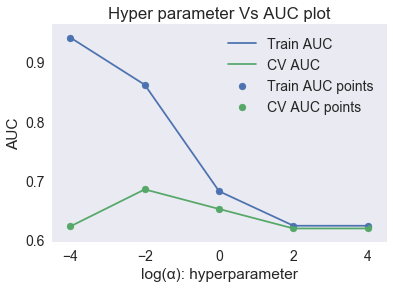

In [172]:
#L2
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
from sklearn import calibration

# Simple CV using for loops.

train_auc_bow = []
cv_auc_bow = []
parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4] #values of alpha
for i in tqdm(parameters):
    clf1=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l2', n_jobs=-1,class_weight='balanced')
    clf1.fit(X_tr_bow, y_train)
    #using calibrated classifier to obtain probabilities of the class labels
    #https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
    calib1=calibration.CalibratedClassifierCV(base_estimator=clf1, method='isotonic', cv='prefit')
    calib1.fit(X_cv_bow,y_cv)
    y_train_pred = batch_predict(calib1, X_tr_bow)
    y_cv_pred = batch_predict(calib1, X_cv_bow)
    train_auc_bow.append(roc_auc_score(y_train,y_train_pred))
    cv_auc_bow.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log10(parameters), train_auc_bow, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_bow, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_bow, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_bow, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#### SVM with L1 regularization


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 12.50s/it]

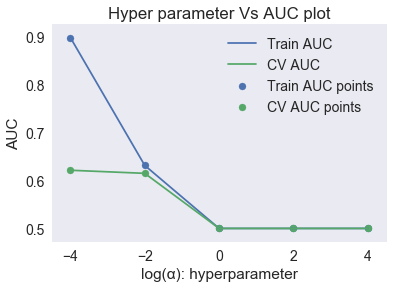

In [175]:
#L1
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn import linear_model

# Simple CV using for loops.

train_auc_bow = []
cv_auc_bow = []
parameters = [10**-4, 10**-2, 10**0, 10**2, 10**4] #values of alpha
for i in tqdm(parameters):
    clf1=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l1', n_jobs=-1,class_weight='balanced')
    clf1.fit(X_tr_bow, y_train)
    calib1=calibration.CalibratedClassifierCV(base_estimator=clf1, method='isotonic', cv='prefit')
    calib1.fit(X_cv_bow,y_cv)
    y_train_pred = batch_predict(calib1, X_tr_bow)
    y_cv_pred = batch_predict(calib1, X_cv_bow)
    train_auc_bow.append(roc_auc_score(y_train,y_train_pred))
    cv_auc_bow.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(np.log10(parameters), train_auc_bow, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_bow, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_bow, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_bow, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#### 1.5.1.2 Testing the performance of the model on test data & plotting ROC Curves for train & test data

##### Using L1 regularizer

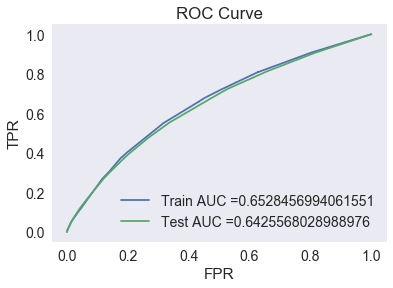

In [194]:
best_alpha = 0.01 

clf2= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l1', n_jobs=-1,class_weight='balanced')
clf2.fit(X_tr_bow, y_train)
calib2=calibration.CalibratedClassifierCV(base_estimator=clf2, method='isotonic', cv='prefit')
calib2.fit(X_test_bow,y_test)
y_train_pred_bow_best = batch_predict(calib2, X_tr_bow)
y_test_pred_bow_best = batch_predict(calib2, X_test_bow)
train_tpr_bow, train_fpr_bow, tr_thresholds_bow = roc_curve(y_train, y_train_pred_bow_best)
test_tpr_bow, test_fpr_bow, te_thresholds_bow = roc_curve(y_test, y_test_pred_bow_best)

plt.plot(train_tpr_bow, train_fpr_bow,label="Train AUC ="+str(auc(train_tpr_bow, train_fpr_bow)))
plt.plot(test_tpr_bow, test_fpr_bow, label="Test AUC ="+str(auc(test_tpr_bow, test_fpr_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

##### Using L2 regularizer

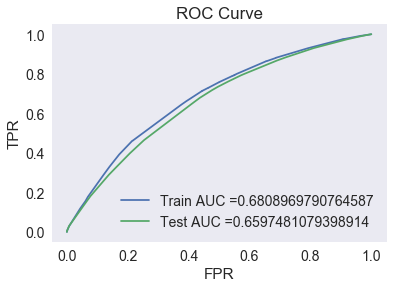

In [195]:
best_alpha = 1 

clf2= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l2', n_jobs=-1,class_weight='balanced')
clf2.fit(X_tr_bow, y_train)

calib2=calibration.CalibratedClassifierCV(base_estimator=clf2, method='isotonic', cv='prefit')
calib2.fit(X_test_bow,y_test)

y_train_pred_bow_best = batch_predict(calib2, X_tr_bow)
y_test_pred_bow_best = batch_predict(calib2, X_test_bow)

train_tpr_bow, train_fpr_bow, tr_thresholds_bow = roc_curve(y_train, y_train_pred_bow_best)
test_tpr_bow, test_fpr_bow, te_thresholds_bow = roc_curve(y_test, y_test_pred_bow_best)

plt.plot(train_tpr_bow, train_fpr_bow,label="Train AUC ="+str(auc(train_tpr_bow, train_fpr_bow)))
plt.plot(test_tpr_bow, test_fpr_bow, label="Test AUC ="+str(auc(test_tpr_bow, test_fpr_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

#### Summary:
- From the above plots, I would choose the SVM model with L2 regularization penalty & alpha= 1 (10**0).

In [88]:
## we will pick a threshold that will give the least fpr

def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("The maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)),"for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("="*100)

In [89]:
#function to get heatmap of confusion matrix
# Reference: https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

def cm_heatmap(cm):
    #y_pred = clf.predict(X_te)
    df_cm = pd.DataFrame(cm, range(2),range(2))
    df_cm.columns = ['Predicted NO','Predicted YES']
    df_cm = df_cm.rename({0: 'Actual NO', 1: 'Actual YES'})
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='d')

#### 1.5.1.3 Confusion matrices: For best alpha

In [196]:
from sklearn.metrics import confusion_matrix
best_t_bow = find_best_threshold(tr_thresholds_bow, train_fpr_bow, train_tpr_bow)
print("Train confusion matrix")
cm_train_bow=confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow_best, best_t_bow))
print(cm_train_bow)
print("Test confusion matrix")
cm_test_bow=confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow_best, best_t_bow))
print(cm_test_bow)

The maximum value of tpr*(1-fpr) 0.13400710060655058 for threshold 0.865
Train confusion matrix
[[ 2167  1296]
 [ 6797 12185]]
Test confusion matrix
[[1508 1038]
 [4953 9001]]


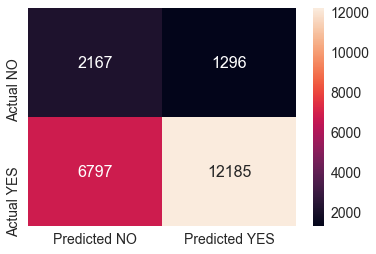

In [197]:
# confusion matrix heatmap for train data
cm_heatmap(cm_train_bow)

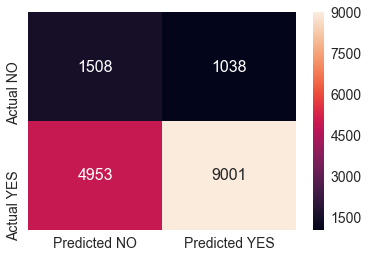

In [198]:
# confusion matrix heatmap for test data
cm_heatmap(cm_test_bow)

### 1.5.2 Set 2: TFIDF featurization

#### 1.5.2.1 Hyper parameter tuning

##### Using L2 regularizer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.04it/s]

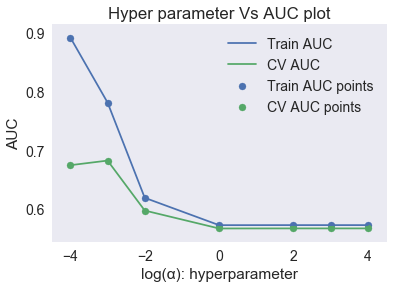

In [182]:
#L2 regularizer
# Simple CV using for loops.

train_auc_tfidf = []
cv_auc_tfidf = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4] #values of alpha
for i in tqdm(parameters):
    clf3=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l2', n_jobs=-1,class_weight='balanced')
    clf3.fit(X_tr_tfidf, y_train)
    
    calib3=calibration.CalibratedClassifierCV(base_estimator=clf3, method='isotonic', cv='prefit')
    calib3.fit(X_cv_tfidf,y_cv)

    y_train_pred_tfidf = batch_predict(calib3, X_tr_tfidf)
    y_cv_pred_tfidf = batch_predict(calib3, X_cv_tfidf)
    train_auc_tfidf.append(roc_auc_score(y_train,y_train_pred_tfidf))
    cv_auc_tfidf.append(roc_auc_score(y_cv, y_cv_pred_tfidf))

plt.plot(np.log10(parameters), train_auc_tfidf, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_tfidf, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_tfidf, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_tfidf, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

##### Using L1 regularizer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.73it/s]

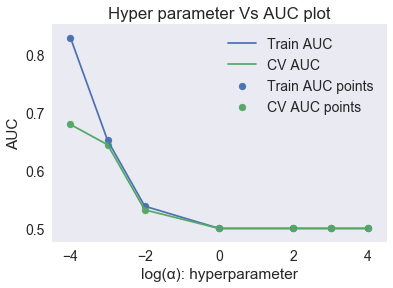

In [183]:
#L1 regularizer
# Simple CV using for loops.

train_auc_tfidf = []
cv_auc_tfidf = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4] #values of alpha
for i in tqdm(parameters):
    clf3=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l1', n_jobs=-1,class_weight='balanced')
    clf3.fit(X_tr_tfidf, y_train)
    
    calib3=calibration.CalibratedClassifierCV(base_estimator=clf3, method='isotonic', cv='prefit')
    calib3.fit(X_cv_tfidf,y_cv)
    
    y_train_pred_tfidf = batch_predict(calib3, X_tr_tfidf)
    y_cv_pred_tfidf = batch_predict(calib3, X_cv_tfidf)
    train_auc_tfidf.append(roc_auc_score(y_train,y_train_pred_tfidf))
    cv_auc_tfidf.append(roc_auc_score(y_cv, y_cv_pred_tfidf))

plt.plot(np.log10(parameters), train_auc_tfidf, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_tfidf, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_tfidf, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_tfidf, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#### 1.5.2.2 Testing the performance of the model on test data & plotting ROC Curves for train & test data

##### Using L2 regularizer

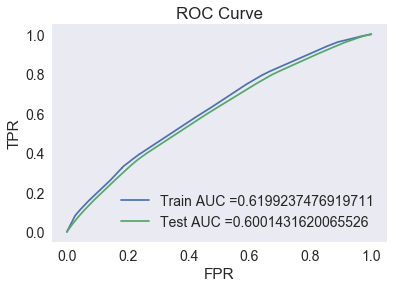

In [189]:
best_alpha = 0.01

clf4= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l2', n_jobs=-1,class_weight='balanced')
clf4.fit(X_tr_tfidf, y_train)
calib4=calibration.CalibratedClassifierCV(base_estimator=clf4, method='isotonic', cv='prefit')
calib4.fit(X_test_tfidf,y_test)
y_train_pred_tfidf_best = batch_predict(calib4, X_tr_tfidf)
y_test_pred_tfidf_best = batch_predict(calib4, X_test_tfidf)

train_tpr_tfidf, train_fpr_tfidf, tr_thresholds_tfidf = roc_curve(y_train, y_train_pred_tfidf_best)
test_tpr_tfidf, test_fpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_pred_tfidf_best)

plt.plot(train_tpr_tfidf, train_fpr_tfidf,label="Train AUC ="+str(auc(train_tpr_tfidf, train_fpr_tfidf)))
plt.plot(test_tpr_tfidf, test_fpr_tfidf, label="Test AUC ="+str(auc(test_tpr_tfidf, test_fpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

##### Using L1 regularizer

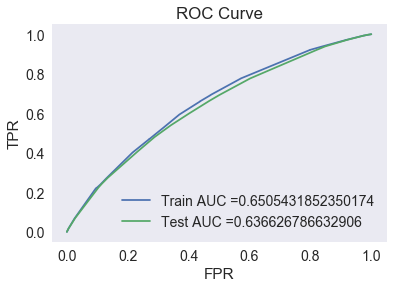

In [190]:
best_alpha = 0.001

clf4= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l1', n_jobs=-1,class_weight='balanced')
clf4.fit(X_tr_tfidf, y_train)
calib4=calibration.CalibratedClassifierCV(base_estimator=clf4, method='isotonic', cv='prefit')
calib4.fit(X_test_tfidf,y_test)
y_train_pred_tfidf_best = batch_predict(calib4, X_tr_tfidf)
y_test_pred_tfidf_best = batch_predict(calib4, X_test_tfidf)

train_tpr_tfidf, train_fpr_tfidf, tr_thresholds_tfidf = roc_curve(y_train, y_train_pred_tfidf_best)
test_tpr_tfidf, test_fpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_pred_tfidf_best)

plt.plot(train_tpr_tfidf, train_fpr_tfidf,label="Train AUC ="+str(auc(train_tpr_tfidf, train_fpr_tfidf)))
plt.plot(test_tpr_tfidf, test_fpr_tfidf, label="Test AUC ="+str(auc(test_tpr_tfidf, test_fpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

#### Summary:

- From the above plots, I would choose the SVM model with L1 regularization penalty & alpha= 0.001 (10**-3).

#### 1.5.2.3 Confusion matrices: For best alpha

In [191]:
from sklearn.metrics import confusion_matrix
best_t_tfidf = find_best_threshold(tr_thresholds_tfidf, train_fpr_tfidf, train_tpr_tfidf)
print("Train confusion matrix")
cm_train_tfidf=confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf_best, best_t_tfidf))
print(cm_train_tfidf)
print("Test confusion matrix")
cm_test_tfidf=confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf_best, best_t_tfidf))
print(cm_test_tfidf)

The maximum value of tpr*(1-fpr) 0.15006578112072555 for threshold 0.859
Train confusion matrix
[[ 2355  1108]
 [ 8903 10079]]
Test confusion matrix
[[1677  869]
 [6428 7526]]


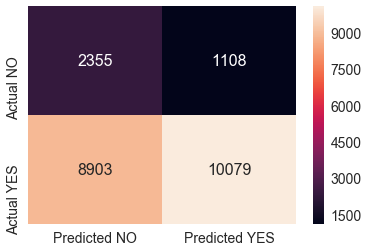

In [192]:
# confusion matrix heatmap for train data
cm_heatmap(cm_train_tfidf)

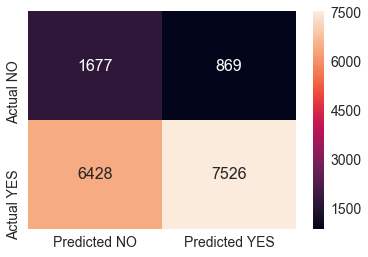

In [193]:
# confusion matrix heatmap for test data
cm_heatmap(cm_test_tfidf)

### 1.5.3 Set 3: AvgW2V featurization

#### 1.5.3.1 Hyper parameter tuning

##### Using L2 regularizer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.64s/it]

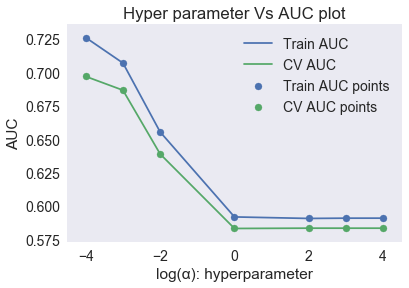

In [199]:
# Simple CV using for loops.

train_auc_avg = []
cv_auc_avg = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4] #values of α
for i in tqdm(parameters):
    clf5=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l2', n_jobs=-1,class_weight='balanced')
    clf5.fit(X_tr_avgw2v, y_train)
    
    calib5=calibration.CalibratedClassifierCV(base_estimator=clf5, method='isotonic', cv='prefit')
    calib5.fit(X_cv_avgw2v,y_cv)

    y_train_pred_avg = batch_predict(calib5, X_tr_avgw2v)
    y_cv_pred_avg = batch_predict(calib5, X_cv_avgw2v)
    train_auc_avg.append(roc_auc_score(y_train,y_train_pred_avg))
    cv_auc_avg.append(roc_auc_score(y_cv, y_cv_pred_avg))

plt.plot(np.log10(parameters), train_auc_avg, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_avg, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_avg, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_avg, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

##### Using L1 regularizer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.50s/it]

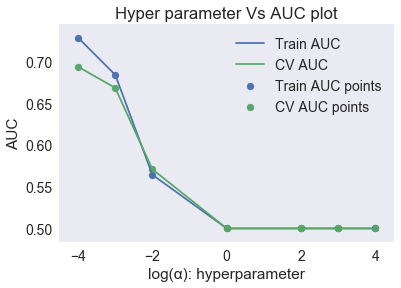

In [200]:
# Simple CV using for loops.

train_auc_avg = []
cv_auc_avg = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4] #values of α
for i in tqdm(parameters):
    clf5=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l1', n_jobs=-1,class_weight='balanced')
    clf5.fit(X_tr_avgw2v, y_train)
    calib5=calibration.CalibratedClassifierCV(base_estimator=clf5, method='isotonic', cv='prefit')
    calib5.fit(X_cv_avgw2v,y_cv)
    y_train_pred_avg = batch_predict(calib5, X_tr_avgw2v)
    y_cv_pred_avg = batch_predict(calib5, X_cv_avgw2v)
    train_auc_avg.append(roc_auc_score(y_train,y_train_pred_avg))
    cv_auc_avg.append(roc_auc_score(y_cv, y_cv_pred_avg))

plt.plot(np.log10(parameters), train_auc_avg, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_avg, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_avg, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_avg, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#### 1.5.3.2 Testing the performance of the model on test data & plotting ROC Curves for train & test data

##### Using L2 regularizer

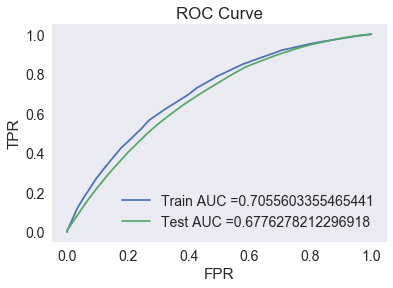

In [205]:
best_alpha = 0.001

clf6= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l2', n_jobs=-1,class_weight='balanced')
clf6.fit(X_tr_avgw2v, y_train)
calib6=calibration.CalibratedClassifierCV(base_estimator=clf6, method='isotonic', cv='prefit')
calib6.fit(X_test_avgw2v,y_test)
y_train_pred_avg_best = batch_predict(calib6, X_tr_avgw2v)
y_test_pred_avg_best = batch_predict(calib6, X_test_avgw2v)

train_tpr_avg, train_fpr_avg, tr_thresholds_avg = roc_curve(y_train, y_train_pred_avg_best)
test_tpr_avg, test_fpr_avg, te_thresholds_avg = roc_curve(y_test, y_test_pred_avg_best)

plt.plot(train_tpr_avg, train_fpr_avg,label="Train AUC ="+str(auc(train_tpr_avg, train_fpr_avg)))
plt.plot(test_tpr_avg, test_fpr_avg, label="Test AUC ="+str(auc(test_tpr_avg, test_fpr_avg)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

##### Using L1 regularizer

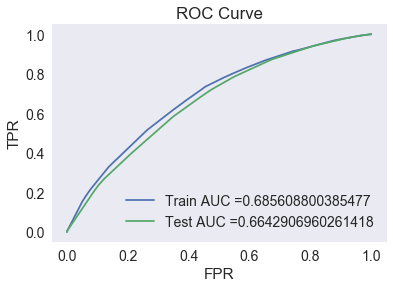

In [204]:
best_alpha = 0.001

clf6= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l1', n_jobs=-1,class_weight='balanced')
clf6.fit(X_tr_avgw2v, y_train)
calib6=calibration.CalibratedClassifierCV(base_estimator=clf6, method='isotonic', cv='prefit')
calib6.fit(X_test_avgw2v,y_test)
y_train_pred_avg_best = batch_predict(calib6, X_tr_avgw2v)
y_test_pred_avg_best = batch_predict(calib6, X_test_avgw2v)

train_tpr_avg, train_fpr_avg, tr_thresholds_avg = roc_curve(y_train, y_train_pred_avg_best)
test_tpr_avg, test_fpr_avg, te_thresholds_avg = roc_curve(y_test, y_test_pred_avg_best)

plt.plot(train_tpr_avg, train_fpr_avg,label="Train AUC ="+str(auc(train_tpr_avg, train_fpr_avg)))
plt.plot(test_tpr_avg, test_fpr_avg, label="Test AUC ="+str(auc(test_tpr_avg, test_fpr_avg)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

#### Summary:

- From the above plots, I would choose the SVM model with L2 regularization penalty & alpha=0.001.

#### 1.5.3.3 Confusion matrices: For best alpha

In [206]:
from sklearn.metrics import confusion_matrix
best_t_avg = find_best_threshold(tr_thresholds_avg, train_fpr_avg, train_tpr_avg)
print("Train confusion matrix")
cm_train_avg=confusion_matrix(y_train, predict_with_best_t(y_train_pred_avg_best, best_t_avg))
print(cm_train_avg)
print("Test confusion matrix")
cm_test_avg=confusion_matrix(y_test, predict_with_best_t(y_test_pred_avg_best, best_t_avg))
print(cm_test_avg)

The maximum value of tpr*(1-fpr) 0.12217033246962873 for threshold 0.849
Train confusion matrix
[[ 2349  1114]
 [ 7209 11773]]
Test confusion matrix
[[1443 1103]
 [4261 9693]]


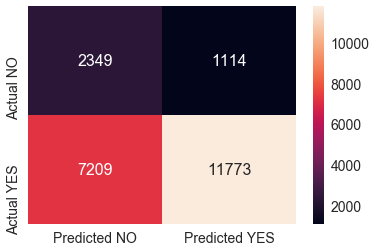

In [207]:
# confusion matrix heatmap for train data
cm_heatmap(cm_train_avg)

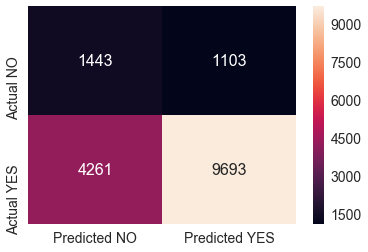

In [208]:
# confusion matrix heatmap for test data
cm_heatmap(cm_test_avg)

### 1.5.4 Set 4: TFIDFW2V featurization

#### 1.5.4.1 Hyper parameter tuning

##### Using L2 regularizer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:22<00:00,  2.67s/it]

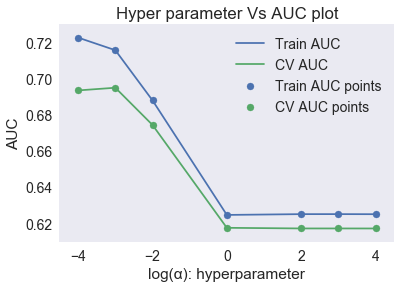

In [209]:
# Simple CV using for loops.

train_auc_tw = []
cv_auc_tw = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in tqdm(parameters):
    clf7=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l2', n_jobs=-1,class_weight='balanced')
    clf7.fit(X_tr_tfidf_w2v, y_train)
    
    calib7=calibration.CalibratedClassifierCV(base_estimator=clf7, method='isotonic', cv='prefit')
    calib7.fit(X_cv_tfidf_w2v,y_cv)

    y_train_pred_tw = batch_predict(calib7, X_tr_tfidf_w2v)
    y_cv_pred_tw = batch_predict(calib7, X_cv_tfidf_w2v)
    train_auc_tw.append(roc_auc_score(y_train,y_train_pred_tw))
    cv_auc_tw.append(roc_auc_score(y_cv, y_cv_pred_tw))

plt.plot(np.log10(parameters), train_auc_tw, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_tw, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_tw, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_tw, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

##### Using L1 regularizer


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.39s/it]

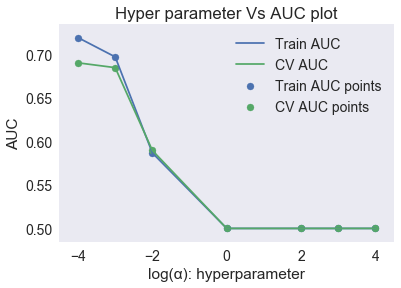

In [210]:
# Simple CV using for loops.

train_auc_tw = []
cv_auc_tw = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4]
for i in tqdm(parameters):
    clf7=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l1', n_jobs=-1,class_weight='balanced')
    clf7.fit(X_tr_tfidf_w2v, y_train)
    calib7=calibration.CalibratedClassifierCV(base_estimator=clf7, method='isotonic', cv='prefit')
    calib7.fit(X_cv_tfidf_w2v,y_cv)
    y_train_pred_tw = batch_predict(calib7, X_tr_tfidf_w2v)
    y_cv_pred_tw = batch_predict(calib7, X_cv_tfidf_w2v)
    train_auc_tw.append(roc_auc_score(y_train,y_train_pred_tw))
    cv_auc_tw.append(roc_auc_score(y_cv, y_cv_pred_tw))

plt.plot(np.log10(parameters), train_auc_tw, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_tw, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_tw, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_tw, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

#### 1.5.4.2 Testing the performance of the model on test data & plotting ROC Curves for train & test data

##### Using L2 regularizer

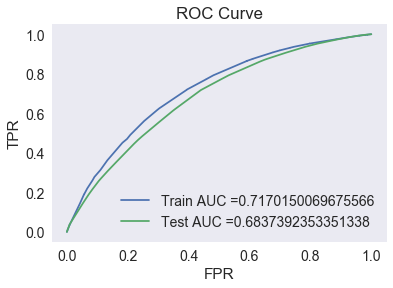

In [211]:
best_alpha = 0.001

clf8= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l2', n_jobs=-1,class_weight='balanced')
clf8.fit(X_tr_tfidf_w2v, y_train)
calib8=calibration.CalibratedClassifierCV(base_estimator=clf8, method='isotonic', cv='prefit')
calib8.fit(X_test_tfidf_w2v,y_test)
y_train_pred_tw_best = batch_predict(calib8, X_tr_tfidf_w2v)
y_test_pred_tw_best = batch_predict(calib8, X_test_tfidf_w2v)

train_tpr_tw, train_fpr_tw, tr_thresholds_tw = roc_curve(y_train, y_train_pred_tw_best)
test_tpr_tw, test_fpr_tw, te_thresholds_tw = roc_curve(y_test, y_test_pred_tw_best)

plt.plot(train_tpr_tw, train_fpr_tw,label="Train AUC ="+str(auc(train_tpr_tw, train_fpr_tw)))
plt.plot(test_tpr_tw, test_fpr_tw, label="Test AUC ="+str(auc(test_tpr_tw, test_fpr_tw)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

##### Using L1 regularizer

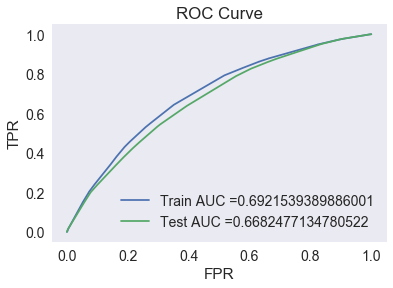

In [212]:
best_alpha = 0.001

clf8= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l1', n_jobs=-1,class_weight='balanced')
clf8.fit(X_tr_tfidf_w2v, y_train)
calib8=calibration.CalibratedClassifierCV(base_estimator=clf8, method='isotonic', cv='prefit')
calib8.fit(X_test_tfidf_w2v,y_test)
y_train_pred_tw_best = batch_predict(calib8, X_tr_tfidf_w2v)
y_test_pred_tw_best = batch_predict(calib8, X_test_tfidf_w2v)

train_tpr_tw, train_fpr_tw, tr_thresholds_tw = roc_curve(y_train, y_train_pred_tw_best)
test_tpr_tw, test_fpr_tw, te_thresholds_tw = roc_curve(y_test, y_test_pred_tw_best)

plt.plot(train_tpr_tw, train_fpr_tw,label="Train AUC ="+str(auc(train_tpr_tw, train_fpr_tw)))
plt.plot(test_tpr_tw, test_fpr_tw, label="Test AUC ="+str(auc(test_tpr_tw, test_fpr_tw)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

#### Summary:

- From the above plots, I would choose the SVM model with L1 regularization penalty & alpha=0.001.

#### 1.5.4.3 Confusion matrices: For best alpha

In [213]:
from sklearn.metrics import confusion_matrix
best_t_tw = find_best_threshold(tr_thresholds_tw, train_fpr_tw, train_tpr_tw)
print("Train confusion matrix")
cm_train_tw=confusion_matrix(y_train, predict_with_best_t(y_train_pred_tw_best, best_t_tw))
print(cm_train_tw)
print("Test confusion matrix")
cm_test_tw=confusion_matrix(y_test, predict_with_best_t(y_test_pred_tw_best, best_t_tw))
print(cm_test_tw)

The maximum value of tpr*(1-fpr) 0.12532808792243655 for threshold 0.854
Train confusion matrix
[[ 2247  1216]
 [ 6775 12207]]
Test confusion matrix
[[1543 1003]
 [5058 8896]]


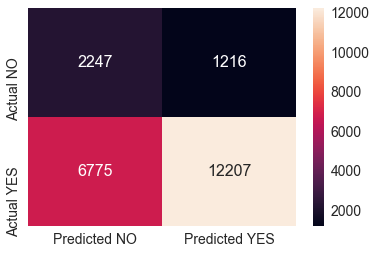

In [214]:
# confusion matrix heatmap for train data
cm_heatmap(cm_train_tw)

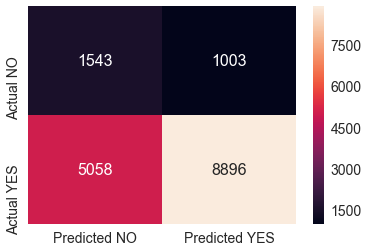

In [215]:
# confusion matrix heatmap for test data
cm_heatmap(cm_test_tw)

### 1.5.5 Set 5: Support Vector Machines with added Features

### 1.5.5.1 To find number of components (n_components) using elbow method

##### Vectorizing preprocessed essays using TFIDFVectorizer

In [142]:
#TFIDF for preprocessed_essays
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,2), max_features=5000)
vectorizer.fit(X_train['preprocessed_essays'].values)

X_train_essay_tfidf_d = vectorizer.transform(X_train['preprocessed_essays'].values)
X_cv_essay_tfidf_d = vectorizer.transform(X_cv['preprocessed_essays'].values)
X_test_essay_tfidf_d = vectorizer.transform(X_test['preprocessed_essays'].values)

In [143]:
print("After vectorization")
print(X_essay_tfidf_d.shape, y_train.shape)
print(X_cv_essay_tfidf_d.shape, y_cv.shape)
print(X_test_essay_tfidf_d.shape, y_test.shape)
print("="*100)

After vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


So we have original d=5000.

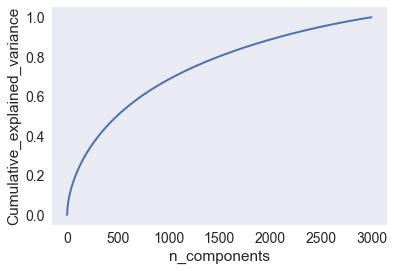

In [145]:
#elbow method

# initializing the SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3000)
svd.fit(X_train_essay_tfidf_d)

percentage_var_explained = svd.explained_variance_/ np.sum(svd.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the SVD spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

- From the cumulative plot of variance & components, we can observe that 80% of variance can be explained with 1500 components. Hence d'=1500. 

In [147]:
from sklearn.decomposition import TruncatedSVD
svd1 = TruncatedSVD(n_components=1500)
svd1.fit(X_train_essay_tfidf_d)
X_train_essay_tfidf_1500 = svd1.transform(X_train_essay_tfidf_d)
X_cv_essay_tfidf_1500 = svd1.transform(X_cv_essay_tfidf_d)
X_test_essay_tfidf_1500 = svd1.transform(X_test_essay_tfidf_d)

In [148]:
print("After reduction")
print(X_train_essay_tfidf_1500.shape, y_train.shape)
print(X_cv_essay_tfidf_1500.shape, y_cv.shape)
print(X_test_essay_tfidf_1500.shape, y_test.shape)
print("="*100)

After reduction
(22445, 1500) (22445,)
(11055, 1500) (11055,)
(16500, 1500) (16500,)


##### Concatenating all numerical, categorical & the reduced dimension features of essay

In [149]:
from scipy.sparse import hstack

X_tr_cn = hstack((X_train_state, X_train_teacher, X_train_grade, X_train_cat, X_train_subcat, X_train_price_norm, X_train_quantity_norm, X_train_projects_norm, X_train_senti_norm, X_train_ewc_norm, X_train_twc_norm,X_train_essay_tfidf_1500)).tocsr()

X_cv_cn = hstack((X_cv_state, X_cv_teacher, X_cv_grade, X_cv_cat, X_cv_subcat, X_cv_price_norm, X_cv_quantity_norm, X_cv_projects_norm, X_cv_senti_norm, X_cv_ewc_norm, X_cv_twc_norm,X_cv_essay_tfidf_1500 )).tocsr()

X_test_cn = hstack((X_test_state, X_test_teacher, X_test_grade, X_test_cat, X_test_subcat, X_test_price_norm, X_test_quantity_norm, X_test_projects_norm, X_test_senti_norm, X_test_ewc_norm, X_test_twc_norm,X_test_essay_tfidf_1500 )).tocsr()

print("Final Data Matrix")
print(X_tr_cn.shape, y_train.shape)
print(X_cv_cn.shape, y_train.shape)
print(X_test_cn.shape, y_train.shape)

Final Data Matrix
(22445, 1605) (22445,)
(11055, 1605) (22445,)
(16500, 1605) (22445,)


### 1.5.5.2 Hyper parameter tuning

##### Using L2 regularizer



  0%|                                                                                                                                            | 0/7 [00:00<?, ?it/s]

 14%|██████████████████▊                                                                                                                 | 1/7 [00:10<01:02, 10.43s/it]

 29%|█████████████████████████████████████▋                                                                                              | 2/7 [00:13<00:40,  8.11s/it]

 43%|████████████████████████████████████████████████████████▌                                                                           | 3/7 [00:15<00:25,  6.46s/it]

 57%|███████████████████████████████████████████████████████████████████████████▍                                                        | 4/7 [00:17<00:15,  5.19s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5/7 [00:19<00:

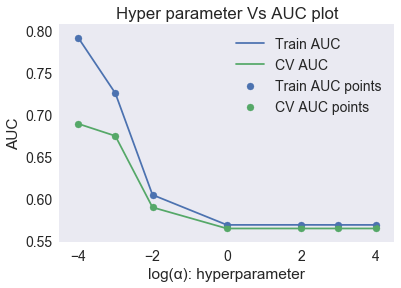

In [217]:
train_auc_cn = []
cv_auc_cn = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4] #values of alpha
for i in tqdm(parameters):
    clf9=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l2', n_jobs=-1,class_weight='balanced')
    clf9.fit(X_tr_cn, y_train)
    
    calib9=calibration.CalibratedClassifierCV(base_estimator=clf9, method='isotonic', cv='prefit')
    calib9.fit(X_cv_cn,y_cv)

    y_train_pred_cn = batch_predict(calib9, X_tr_cn)
    y_cv_pred_cn = batch_predict(calib9, X_cv_cn)
    train_auc_cn.append(roc_auc_score(y_train,y_train_pred_cn))
    cv_auc_cn.append(roc_auc_score(y_cv, y_cv_pred_cn))

plt.plot(np.log10(parameters), train_auc_cn, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_cn, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_cn, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_cn, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

##### Using L1 regularizer



  0%|                                                                                                                                            | 0/7 [00:00<?, ?it/s]

 14%|██████████████████▊                                                                                                                 | 1/7 [00:20<02:05, 20.85s/it]

 29%|█████████████████████████████████████▋                                                                                              | 2/7 [00:29<01:25, 17.08s/it]

 43%|████████████████████████████████████████████████████████▌                                                                           | 3/7 [00:33<00:52, 13.24s/it]

 57%|███████████████████████████████████████████████████████████████████████████▍                                                        | 4/7 [00:37<00:31, 10.46s/it]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5/7 [00:41<00:

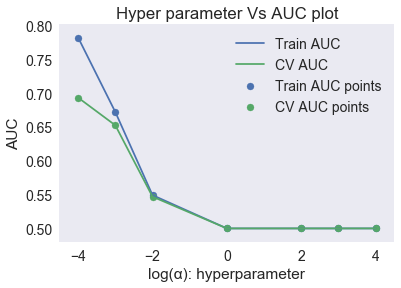

In [218]:
train_auc_cn = []
cv_auc_cn = []
parameters = [10**-4,10**-3, 10**-2, 10**0, 10**2, 10**3, 10**4] #values of alpha
for i in tqdm(parameters):
    clf9=linear_model.SGDClassifier(loss='hinge',alpha=i, penalty='l1', n_jobs=-1,class_weight='balanced')
    clf9.fit(X_tr_cn, y_train)
    
    calib9=calibration.CalibratedClassifierCV(base_estimator=clf9, method='isotonic', cv='prefit')
    calib9.fit(X_cv_cn,y_cv)

    y_train_pred_cn = batch_predict(calib9, X_tr_cn)
    y_cv_pred_cn = batch_predict(calib9, X_cv_cn)
    train_auc_cn.append(roc_auc_score(y_train,y_train_pred_cn))
    cv_auc_cn.append(roc_auc_score(y_cv, y_cv_pred_cn))

plt.plot(np.log10(parameters), train_auc_cn, label='Train AUC')
plt.plot(np.log10(parameters), cv_auc_cn, label='CV AUC')

plt.scatter(np.log10(parameters), train_auc_cn, label='Train AUC points')
plt.scatter(np.log10(parameters), cv_auc_cn, label='CV AUC points')
plt.legend()
plt.xlabel("log(α): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

### 1.5.5.3 Testing the performance of the model on test data & plotting ROC Curves for train & test data

##### Using L2 regularizer

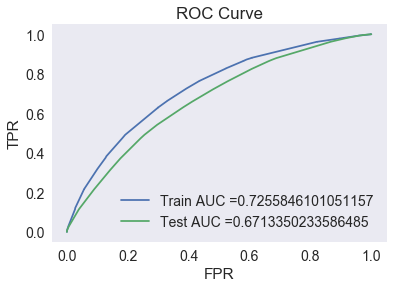

In [219]:
best_alpha = 0.001

clf10= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l2', n_jobs=-1,class_weight='balanced')
clf10.fit(X_tr_cn, y_train)
calib10=calibration.CalibratedClassifierCV(base_estimator=clf10, method='isotonic', cv='prefit')
calib10.fit(X_test_cn,y_test)
y_train_pred_cn_best = batch_predict(calib10, X_tr_cn)
y_test_pred_cn_best = batch_predict(calib10, X_test_cn)

train_tpr_cn, train_fpr_cn, tr_thresholds_cn = roc_curve(y_train, y_train_pred_cn_best)
test_tpr_cn, test_fpr_cn, te_thresholds_cn = roc_curve(y_test, y_test_pred_cn_best)

plt.plot(train_tpr_cn, train_fpr_cn,label="Train AUC ="+str(auc(train_tpr_cn, train_fpr_cn)))
plt.plot(test_tpr_cn, test_fpr_cn, label="Test AUC ="+str(auc(test_tpr_cn, test_fpr_cn)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

##### Using L1 regularizer

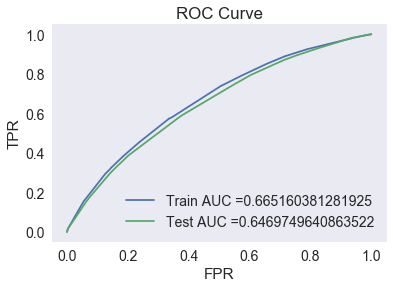

In [220]:
best_alpha = 0.001

clf10= linear_model.SGDClassifier(loss='hinge',alpha=best_alpha, penalty='l1', n_jobs=-1,class_weight='balanced')
clf10.fit(X_tr_cn, y_train)

calib10=calibration.CalibratedClassifierCV(base_estimator=clf10, method='isotonic', cv='prefit')
calib10.fit(X_test_cn,y_test)

y_train_pred_cn_best = batch_predict(calib10, X_tr_cn)
y_test_pred_cn_best = batch_predict(calib10, X_test_cn)

train_tpr_cn, train_fpr_cn, tr_thresholds_cn = roc_curve(y_train, y_train_pred_cn_best)
test_tpr_cn, test_fpr_cn, te_thresholds_cn = roc_curve(y_test, y_test_pred_cn_best)

plt.plot(train_tpr_cn, train_fpr_cn,label="Train AUC ="+str(auc(train_tpr_cn, train_fpr_cn)))
plt.plot(test_tpr_cn, test_fpr_cn, label="Test AUC ="+str(auc(test_tpr_cn, test_fpr_cn)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

#### Summary:

- From the above plots, I would choose the SVM model with L1 regularization penalty & alpha=0.001.

### 1.5.5.4 Confusion matrices: For best alpha

In [221]:
from sklearn.metrics import confusion_matrix
best_t_cn = find_best_threshold(tr_thresholds_cn, train_fpr_cn, train_tpr_cn)
print("Train confusion matrix")
cm_train_cn=confusion_matrix(y_train, predict_with_best_t(y_train_pred_cn_best, best_t_cn))
print(cm_train_cn)
print("Test confusion matrix")
cm_test_cn=confusion_matrix(y_test, predict_with_best_t(y_test_pred_cn_best, best_t_cn))
print(cm_test_cn)

The maximum value of tpr*(1-fpr) 0.14490485126980032 for threshold 0.842
Train confusion matrix
[[ 2271  1192]
 [ 7991 10991]]
Test confusion matrix
[[1582  964]
 [5714 8240]]


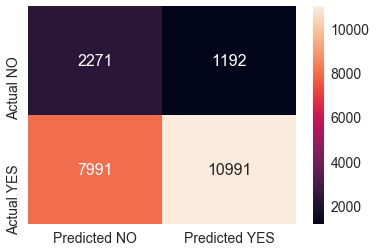

In [222]:
# confusion matrix heatmap for train data
cm_heatmap(cm_train_cn)

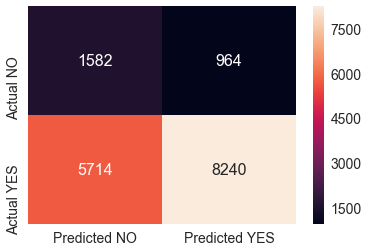

In [223]:
# confusion matrix heatmap for test data
cm_heatmap(cm_test_cn)

## 2.0 Summary

In [161]:
!pip install prettytable

In [224]:
#Ref: http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Vectorizer","Hyperparameter(α)","Regularizer" ,"Test AUC"]
x.add_row(["BOW", 1, "L2", 0.66])
x.add_row(["TFIDF", 0.001, "L1", 0.64])
x.add_row(["Avg W2V", 0.001, "L2", 0.68])
x.add_row(["TFIDF W2V", 0.001, "L1", 0.67])
x.add_row(["Categorical & numerical features: Set-5", 0.001,"L1", 0.65])

print(x)

+-----------------------------------------+-------------------+-------------+----------+
|                Vectorizer               | Hyperparameter(α) | Regularizer | Test AUC |
+-----------------------------------------+-------------------+-------------+----------+
|                   BOW                   |         1         |      L2     |   0.66   |
|                  TFIDF                  |       0.001       |      L1     |   0.64   |
|                 Avg W2V                 |       0.001       |      L2     |   0.68   |
|                TFIDF W2V                |       0.001       |      L1     |   0.67   |
| Categorical & numerical features: Set-5 |       0.001       |      L1     |   0.65   |
+-----------------------------------------+-------------------+-------------+----------+


- It can be observed that the test AUC score of the SVM model using categorical, numerical & reduced essay dimensions was 0.65 which was almost in par with SVM models using text features encoded in the form of BOW, TFIDF, AvgW2V & TFIDF W2V along with categorical & numerical features
- Therefore reducing the dimensions from 5000 to 1500 using truncated SVD yielded a decent performance of the SVM model